In [1]:
# Packages required for calibration
import corrcal  # For performing the likelihood and gradient operations
import numpy as np
from scipy.optimize import minimize  # For running calibration

# Packages to help with covariance model building and simulation
import hera_sim
import vis_cpu  # For coordinate transformations
from astropy import constants, units
from astropy.coordinates import Latitude, Longitude, AltAz
from astropy.coordinates import EarthLocation, SkyCoord
from astropy_healpix import HEALPix  # For interpolating to the image plane
from astropy.time import Time
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from pyradiosky import SkyModel
from pyuvdata import UVBeam  # If using a realistic beam model
from pyuvsim import AnalyticBeam  # If using an analytic beam model

# Other packages
import healpy  # For various operations on the sphere
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d  # For visualization purposes
%matplotlib inline

In [2]:
source_catalog = corrcal.DATA_PATH / "example_source_catalog.npz"
catalog_info = dict(np.load(source_catalog))
fluxes = catalog_info["fluxes"] * getattr(units, str(catalog_info["flux_unit"]))
ra = catalog_info["ra"] * getattr(units, str(catalog_info["ra_unit"]))
dec = catalog_info["dec"] * getattr(units, str(catalog_info["dec_unit"]))

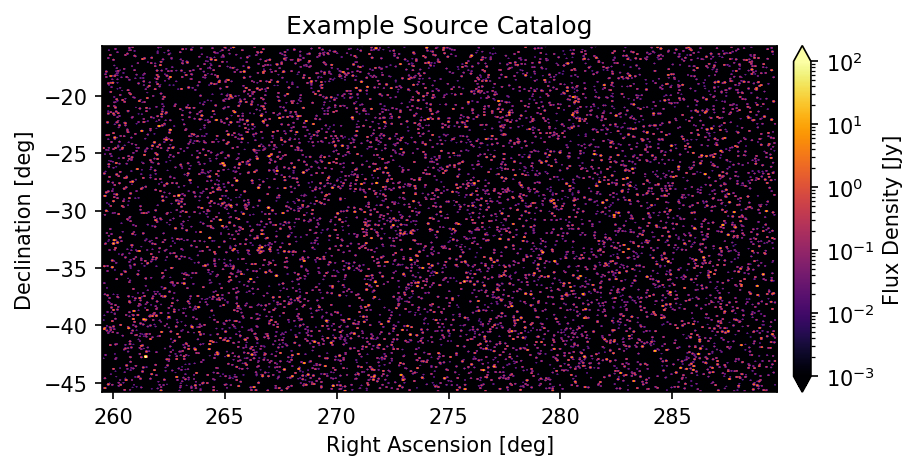

In [3]:
# Bin up the sources and plot the result to visualize the source catalog
buffer = 0.1 * units.deg
n_bins = 1025
ra_bounds = (
    (ra.min() - buffer).to(units.rad).value,
    (ra.max() + buffer).to(units.rad).value,
)
dec_bounds = (
    (dec.min() - buffer).to(units.rad).value,
    (dec.max() + buffer).to(units.rad).value,
)
ra_bins = np.linspace(*ra_bounds, n_bins+1)
dec_bins = np.linspace(*dec_bounds, n_bins+1)
binned_flux = binned_statistic_2d(
    ra.to(units.rad).value,
    dec.to(units.rad).value,
    fluxes.to(units.Jy).value,
    statistic="sum",
    bins=(ra_bins, dec_bins),
)[0]

# Smooth the binned flux to help with visualization.
kernel_width = 1 * units.arcmin.to(units.rad)
plot_ra = 0.5 * (ra_bins[1:]+ra_bins[:-1])
plot_ra -= plot_ra.mean()
plot_dec = 0.5 * (dec_bins[1:]+dec_bins[:-1])
plot_dec -= plot_dec.mean()
kernel = np.exp(
    -0.5 * plot_dec[:,None]**2 / kernel_width**2
) * np.exp(-0.5 * plot_ra[None,:]**2 / kernel_width**2)
smoothed_flux = np.abs(
    fftshift(ifft2(fft2(kernel) * fft2(binned_flux)))
)

# Now set up the plotting elements.
norm = plt.cm.colors.LogNorm(vmin=1e-3, vmax=1e2)
cmap = plt.cm.inferno.copy()
cmap.set_bad('k')
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
extent = np.array(ra_bounds + dec_bounds) * units.rad.to(units.deg)

# Finally, actually make the plot.
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("Example Source Catalog")
ax.imshow(smoothed_flux, origin="lower", aspect="auto", norm=norm, cmap=cmap, extent=extent)
fig.colorbar(smap, ax=ax, label="Flux Density [Jy]", extend="both", pad=0.02);

In [4]:
max_Tsky = 500 * units.K
nside = 64
ell_max = 3*nside - 1
ells = np.arange(ell_max+1, dtype=float)
sky_pspec = 1 / (1+ells)**2
Tsky = healpy.synfast(sky_pspec, nside) * units.K
Tsky += np.abs(Tsky.min())  # Considering only emission and not absorption
Tsky *= max_Tsky / Tsky.max()

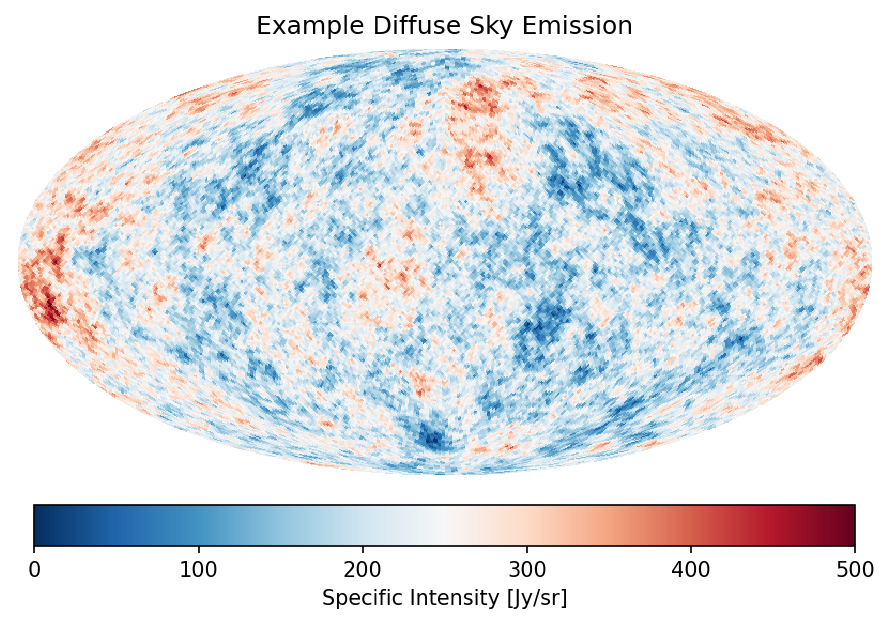

In [5]:
# Quickly visualize the diffuse component
plt.figure(figsize=(6,4), dpi=150)
healpy.mollview(
    Tsky.value,
    fig=1,
    title="",
    cmap="RdBu_r",
    cbar=False,
    norm=None,
    min=Tsky[Tsky>0].min().value,
    max=Tsky.max().value,
)

# Manually make the colorbar and title
norm = plt.cm.colors.Normalize(vmin=0, vmax=Tsky.max().value)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(
    smap,
    ax=plt.gca(),
    orientation="horizontal",
    label="Specific Intensity [Jy/sr]",
    shrink=0.95,
    pad=0.05,
)
plt.title("Example Diffuse Sky Emission");

In [6]:
# Required parameters for making a UVData object
obstime = 2459917.00243  # Julian date
integration_time = 10  # seconds
Ntimes = 1
freq = 150e6  # Hz
channel_width = 100e3  # Hz
Nfreqs = 1
polarizations = ["xx",]
array_layout = hera_sim.antpos.hex_array(3, outriggers=0, split_core=False)
latitude = -30.721527099609585  # Degrees
longitude = 21.42830467224121  # Degrees
altitude = 1073.0000000121072  # Meters

# Additional information.
diameter = 14

In [7]:
# Create the UVData object.
src_uvdata = hera_sim.io.empty_uvdata(
    Ntimes=Ntimes,
    start_time=obstime,
    integration_time=integration_time,
    Nfreqs=Nfreqs,
    start_freq=freq,
    channel_width=channel_width,
    array_layout=array_layout,
    polarizations=polarizations,
    telescope_location=[latitude, longitude, altitude],
)
# For sanity checks later.
diff_uvdata = src_uvdata.copy()

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.


In [8]:
# Create the beam model.
beam = AnalyticBeam("airy", diameter=diameter)
beam_ids = [0,] * src_uvdata.Nants_data

In [9]:
# Generate the SkyModel for the source catalog.
source_stokes = np.zeros((4, 1, fluxes.size), dtype=float) * units.Jy
source_stokes[0,0] = fluxes
source_model = SkyModel(
    name=np.arange(fluxes.size).astype(str),
    ra=Longitude(ra),
    dec=Latitude(dec),
    stokes=source_stokes,
    spectral_type="flat",  # No spectral evolution
    component_type="point",
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [10]:
# Generate the SkyModel for the diffuse emission.
diffuse_stokes = np.zeros((4, 1, Tsky.size), dtype=float) * units.K
diffuse_stokes[0,0] = Tsky
diffuse_model = SkyModel(
    stokes=diffuse_stokes,
    hpx_inds=np.arange(Tsky.size),
    spectral_type="flat",
    component_type="healpix",
    nside=nside,
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [11]:
# Simulate the diffuse visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=diff_uvdata,
    sky_model=diffuse_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)
simulation.simulate();

In [12]:
# Simulate the point source visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=src_uvdata,
    sky_model=source_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)
simulation.simulate();

In [13]:
uvdata = src_uvdata.copy()
uvdata.data_array += diff_uvdata.data_array

In [14]:
# Choosing this as the minimum baseline length more strongly enforces the
# approximation that there is no shared information between different redundant
# groups sourced from diffuse emission.
min_bl_length = np.sqrt(2) * diameter
min_group_size = 5  # This is somewhat arbitrary, but helps with computational cost
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_length=min_bl_length, min_group_size=min_group_size
)

In [15]:
enu_antpos = uvdata.get_ENU_antpos()[0]
baselines = enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
np.allclose(baselines[edges[0]], baselines[edges[0]:edges[1]])

True

In [16]:
# We need the beam power rather than the far-field response
beam.efield_to_power()

# The diffuse emission needs to be converted from K to Jy
diffuse_model.kelvin_to_jansky()
Tsky = diffuse_model.stokes[0,0].value

# Since the simulation is perfectly redundant, we'll just use one eigenmode
n_eig = 1

In [17]:
# Prepare the direction cosine grid.
uvws = freq * baselines / constants.c.si.value
u_max = np.linalg.norm(uvws, axis=1).max()
n_l = int(8 * u_max)
if n_l % 2 == 0:
    n_l += 1  # Ensure (l,m) = (0,0) is included.
lm_grid = np.linspace(-1, 1, n_l)  # Horizon-to-horizon
measure = (lm_grid[1]-lm_grid[0]) ** 2

In [18]:
# Prepare a local frame for coordinate transformations
observatory = EarthLocation(*uvdata.telescope_location*units.m)
local_frame = AltAz(
    location=observatory, obstime=Time(obstime, format="jd")
)

In [19]:
# Now interpolate the beam and sky to the (l,m) grid.
gridded_beam = np.zeros((n_l, n_l), dtype=float)
flat_Tsky = np.zeros_like(gridded_beam)
hpx_grid = HEALPix(nside=nside, order="ring", frame="icrs")

# This might not be the most efficient way, but it works.
for row, m in enumerate(lm_grid):
    # First, figure out what's above the horizon.
    l_mag = np.sqrt(m**2 + lm_grid**2)
    select = l_mag < 1
    if select.sum() == 0:
        continue  # There's nothing to do.
        
    # Compute the azimuth and zenith angle for each of these points.
    indices = np.argwhere(select).flatten()
    za = np.arcsin(l_mag[select])
    az = np.arctan2(m, lm_grid[select])
    
    # Interpolate the beam.
    beam_vals = beam.interp(
        az_array=az, za_array=za, freq_array=np.array([freq])
    )[0][0,0]
    if beam_vals.ndim == 3:
        # It seems like this differs between versions of pyuvsim.
        beam_vals = beam_vals[0,0]
    gridded_beam[row,select] = beam_vals
    
    # Interpolate the sky intensity.
    coords = SkyCoord(
        Longitude(np.pi/2 - az, unit="rad"),  # astropy uses E of N
        Latitude(np.pi/2 - za, unit="rad"),
        frame=local_frame,
    ).transform_to("icrs")
    flat_Tsky[row,select] = hpx_grid.interpolate_bilinear_skycoord(
        coords, Tsky
    ) / np.sqrt(1 - l_mag[select]**2)  # Apply sky projection effects.
    
# Wrap up preparations by computing the sky power spectrum.
sky_pspec = np.abs(
    np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(flat_Tsky * measure)))
) ** 2

In [20]:
# Now compute the diffuse matrix.
LM = np.array(np.meshgrid(lm_grid, lm_grid))
diff_mat = np.zeros((edges[-1], n_eig), dtype=complex)
for grp, (start, stop) in enumerate(zip(edges, edges[1:])):
    # Compute the beam transfer function for this block.
    fringe = np.exp(
        -2j * np.pi * np.einsum("bi,ilm->blm", uvws[start:stop,:2], LM)
    )
    kernel = np.fft.fftshift(
        np.fft.fft2(
            np.fft.ifftshift(
                gridded_beam[None,...] * fringe, axes=(1,2)
            ), axes=(1,2)
        ), axes=(1,2)
    )
    
    # Compute this block of the diffuse covariance.
    block = measure * np.einsum(
        "puv,quv,uv->pq", kernel, kernel.conj(), sky_pspec
    )
    
    # Take the eigendecomposition.
    eigvals, eigvecs = np.linalg.eigh(block)
    if eigvals[0] < eigvals[-1]:
        eigvals = eigvals[::-1]
        eigvecs = eigvecs[:,::-1]
    diff_mat[start:stop] = np.sqrt(eigvals[None,:n_eig]) * eigvecs[:,:n_eig]

In [21]:
# There is a convenient function that will do the calculation.
_diff_mat = corrcal.models.compute_diffuse_matrix(
    Tsky=Tsky,
    nside=nside,
    beam=beam,
    telescope_location=uvdata.telescope_location*units.m,
    obstime=obstime,
    freq=freq,
    enu_antpos=enu_antpos,
    ant_1_array=ant_1_array,
    ant_2_array=ant_2_array,
    edges=edges,
    n_eig=n_eig
)

In [22]:
# Convert the source positions to the local frame.
source_positions = SkyCoord(
    Longitude(ra), Latitude(dec), frame="icrs"
).transform_to(local_frame)

# Perform some selections before picking which sources to use.
above_horizon = source_positions.alt > 0

# This is arbitrary, but within the main lobe is reasonable.
near_zenith = source_positions.alt.deg > 80

# Again, the brightness cutoff is arbitrary.
is_bright = fluxes.to(units.Jy).value > 100

select = near_zenith | (is_bright & above_horizon)

In [23]:
src_az = Longitude(np.pi/2*units.rad - source_positions.az)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select].to(units.Jy).value

In [24]:
# UVBeam has azimuth run from East to North
src_az = Longitude(np.pi/2*units.rad - source_positions.az)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select].to(units.Jy).value

beam_vals = beam.interp(
    az_array=src_az, za_array=src_za, freq_array=np.array([freq]),
)[0][0,0,0]
if beam_vals.ndim == 2:
    # Again, this is a pyuvsim version thing
    beam_vals = beam_vals[0]
weighted_fluxes = beam_vals * src_flux

# Now choose the sources to use for calibration
n_src = 1
sort = np.argsort(weighted_fluxes)[::-1]
src_az = src_az[sort][:n_src]
src_za = src_za[sort][:n_src]

# The factor of 0.5 to match the matvis Stokes convention
src_flux = 0.5 * weighted_fluxes[sort][:n_src]

In [25]:
# Compute the unit vectors pointing to the sources
src_nhat = np.array(
    [np.sin(src_za)*np.cos(src_az), np.sin(src_za)*np.sin(src_az), np.cos(src_za)]
)
src_fringe = np.exp(-2j * np.pi * uvws @ src_nhat)
src_mat = src_flux[None,:] * src_fringe

In [26]:
# Initialize things for making the groups.
reds, _, lens, conj = uvdata.get_redundancies(include_conjugates=True)
conj = set(conj)  # To make lookup faster
ant_1_array = []
ant_2_array = []
edges = [0,]
idx = 0  # To count where we are when building the arrays

# Loop over the redundant groups and build the relevant arrays.
for group, bl_length in zip(reds, lens):
    if (bl_length < min_bl_length) or (len(group) < min_group_size):
        continue
    
    for bl in group:
        # Convert the baseline number into an antenna pair
        ai, aj = uvdata.baseline_to_antnums(bl)
        if bl in conj:
            ai, aj = aj, ai
        ant_1_array.append(ai)
        ant_2_array.append(aj)
        idx += 1
    edges.append(idx)
    
ant_1_array = np.array(ant_1_array)
ant_2_array = np.array(ant_2_array)
edges = np.array(edges)

In [27]:
# There is also a convenience function for this in corrcal
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_length=min_bl_length, min_group_size=min_group_size
)

In [28]:
# Now we can use these arrays to retrieve the data.
data = np.array(
    [
        uvdata.get_data(ai, aj, "xx").flatten()[0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

In [29]:
autocorr = uvdata.get_data(0, 0, "xx")[0,0]
noise_amp = 1e-4 * autocorr  # This is radiometer with dnu dt = 1e8
noise = np.ones(ant_1_array.size, dtype=complex) * noise_amp

In [30]:
# Choose some gain parameters
gain_amp = 1
amp_jitter = 0.1  # 10% jitter in the true gain amplitudes
amp_error = 0.1  # 10% errors in the initial guesses for the gains
phs_error = 0.05  # average error on the gain phase, in radians

# Simulate the gains
n_ants = uvdata.Nants_data
gain_amplitudes = np.random.normal(
    size=n_ants, loc=gain_amp, scale=amp_jitter
)
gain_phases = np.random.uniform(0, 2*np.pi, n_ants)
true_gains = gain_amplitudes * np.exp(1j*gain_phases)

# Now take a perturbation on the true gains as the initial guess
init_amp = gain_amplitudes * np.random.normal(
    size=n_ants, loc=1, scale=amp_error
)
init_phs = gain_phases + np.random.normal(
    size=n_ants, loc=0, scale=phs_error
)
init_gains = init_amp * np.exp(1j*init_phs)

In [31]:
# Now apply the gains to the data.
data *= true_gains[ant_1_array] * true_gains[ant_2_array].conj()

In [32]:
# Create the sparse covariance object.
cov = corrcal.sparse.SparseCov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=src_mat,
    edges=edges,
    n_eig=n_eig,
    isinv=False,
)

In [33]:
# Set up the additional arguments the objective function needs.
gain_scale = 1  # Scaling factor to help with convergence time.
phs_norm = 0.1  # How close to zero phase the calibration solutions should be.
opt_args = (
    cov, data, ant_1_array, ant_2_array, gain_scale, phs_norm
)

# Split up the gains into the real/imaginary parts for calibration.
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = init_gains.real
split_gains[1::2] = init_gains.imag

# Now run the optimization.
result = minimize(
    corrcal.optimize.nll,
    gain_scale*split_gains,
    args=opt_args,
    method="CG",  # Use the conjugate-gradient solver
    jac=corrcal.optimize.grad_nll,
    options=dict(retall=True),
)

Unknown solver options: retall


In [34]:
gain_soln = corrcal.utils.rephase_to_ant(
    result.x[::2] + 1j*result.x[1::2], 0
)
true_gains = corrcal.utils.rephase_to_ant(true_gains, 0)

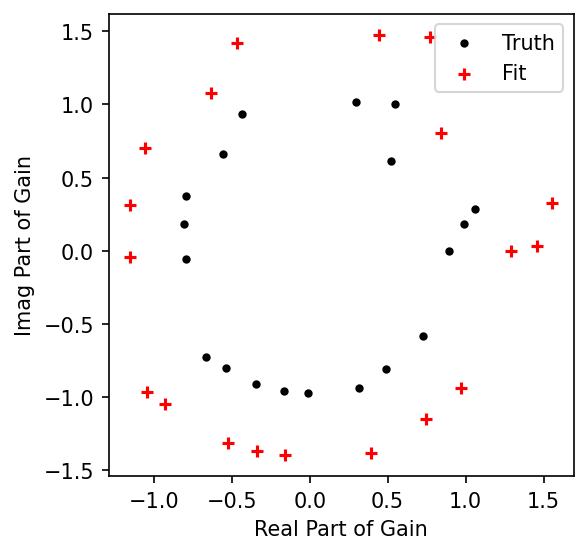

In [35]:
# First, let's look at the gain solutions in the complex plane.
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_xlabel("Real Part of Gain")
ax.set_ylabel("Imag Part of Gain")

ax.scatter(true_gains.real, true_gains.imag, color="k", marker=".", label="Truth")
ax.scatter(gain_soln.real, gain_soln.imag, color="r", marker="+", label="Fit")
ax.legend();